### Quantisation of audio signals

In this notebook, we will quantise and audio signal and listen to the results of different levels of quantisation. We will also look at a method of reducing quantisation noise.

In [1]:
import numpy as np 
from scipy import signal
import sounddevice as sd
from matplotlib import pyplot as plt
import IPython
from IPython.display import Audio, Image
%matplotlib notebook
from IPython.core.display import display, HTML

#### Listening to the effect of the number of bits used for quantisation

In addition to discretising the signals in time, i.e. via the sampling frequency, we also need to pay attention to how the signal is discretised with respect to its amplitude. Discrete amplitudes are determined by the number of bits which are used to represent the signal. Hence using more bits allows more discrete amplitudes to which the continuous signal can be approximated. In the same way that we have a finer time resolution when we increase the sampling frequency, we get a finer amplitude resolution when we increase the number of bits. 

In python, audio signals can be captured using either the number of bits or a floating point representation. By default, in the previous examples the floating point representation was used to capture the signals, but for the following we will only look at using integer bits. More information on the difference between the floating point and bit representation can be found in the following links.

- https://www.sounddevices.com/32-bit-float-files-explained/
- https://docs.python.org/3/tutorial/floatingpoint.html

Another subtle point is that so far we have not really cared about the actual amplitude numbers on the plots, but we should know what they are intended to represent. As the 2nd article above explains, if floating point representations are used, the numbers are approximated with an appropriate binary fraction. On the other hand, when these integer bits are used, say 16 bit or 24 bit representation, the sound device package below outputs the amplitude values in terms of the signed discrete levels, i.e. +/- 2^0, +/- 2^1,...,+/- 2^Nbits, where Nbits is the maximum number of bits (i.e. the decimal value from a [2s complement representation](https://en.wikipedia.org/wiki/Two%27s_complement)). In the following when plotting the amplitudes, we normalise by 2^Nbits. In audio jargon this value is sometimes referred to as 0 dBFS. 

Okay so let's go ahead and record some audio by executing the following cell.

In [31]:
# Record a 32 bit audio signal

duration = 3  # seconds
fs = 16000    # Sampling frequency (Hz)
print ('recording...')
audio_32bit = sd.rec(duration * fs, blocking=True,samplerate=fs, channels=1, dtype='int32') # 32 bit recording
print ('finished recording')



recording...
finished recording


32-bit audio:


<IPython.core.display.Javascript object>


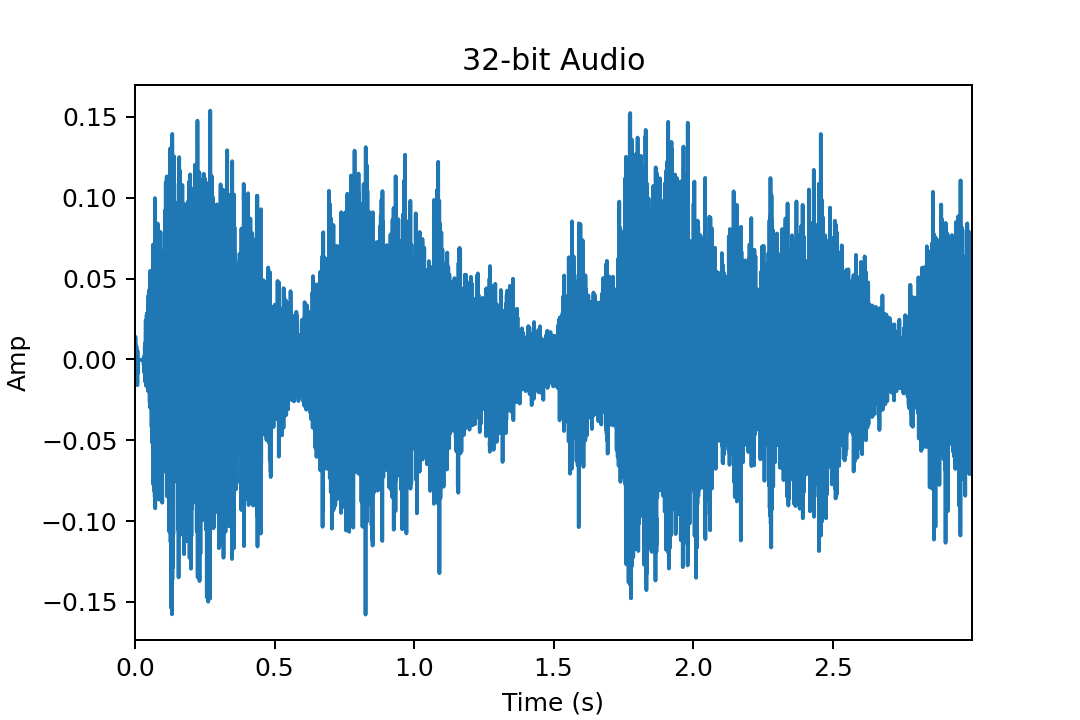

16-bit audio:


<IPython.core.display.Javascript object>


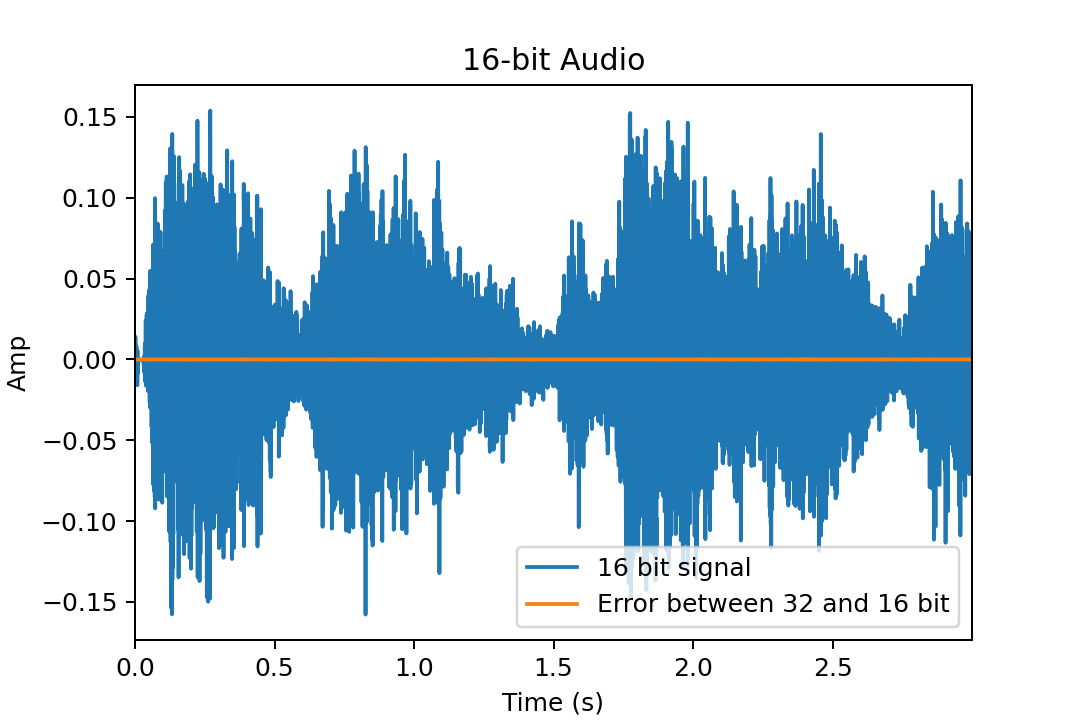

8-bit audio:


<IPython.core.display.Javascript object>


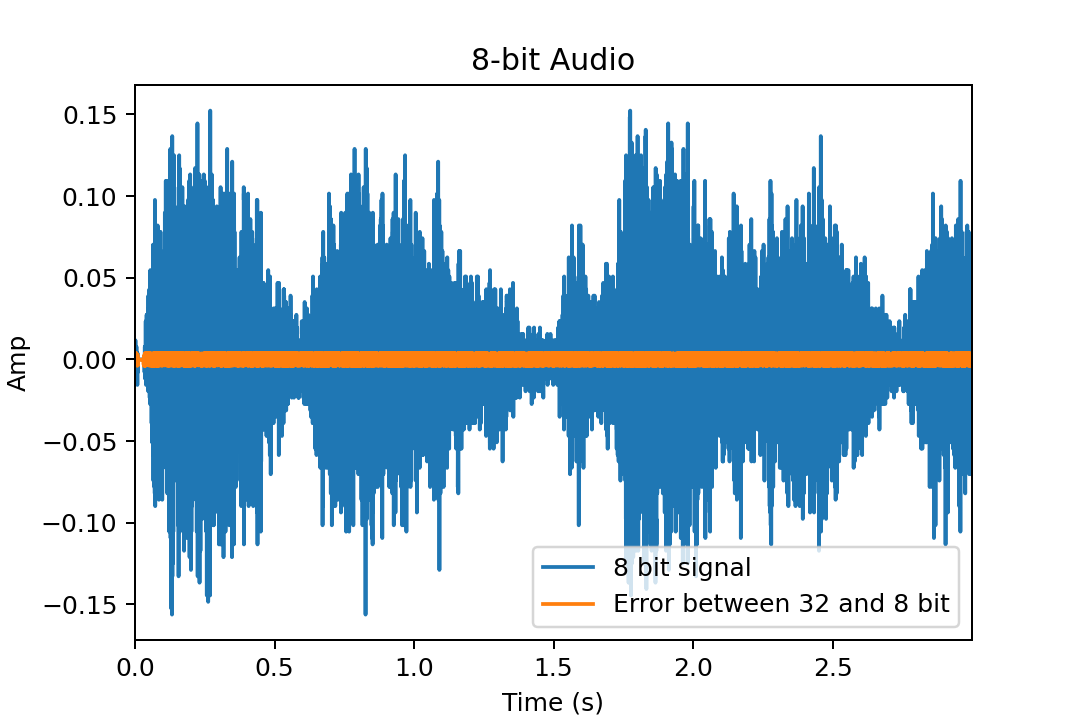

4-bit audio:


<IPython.core.display.Javascript object>


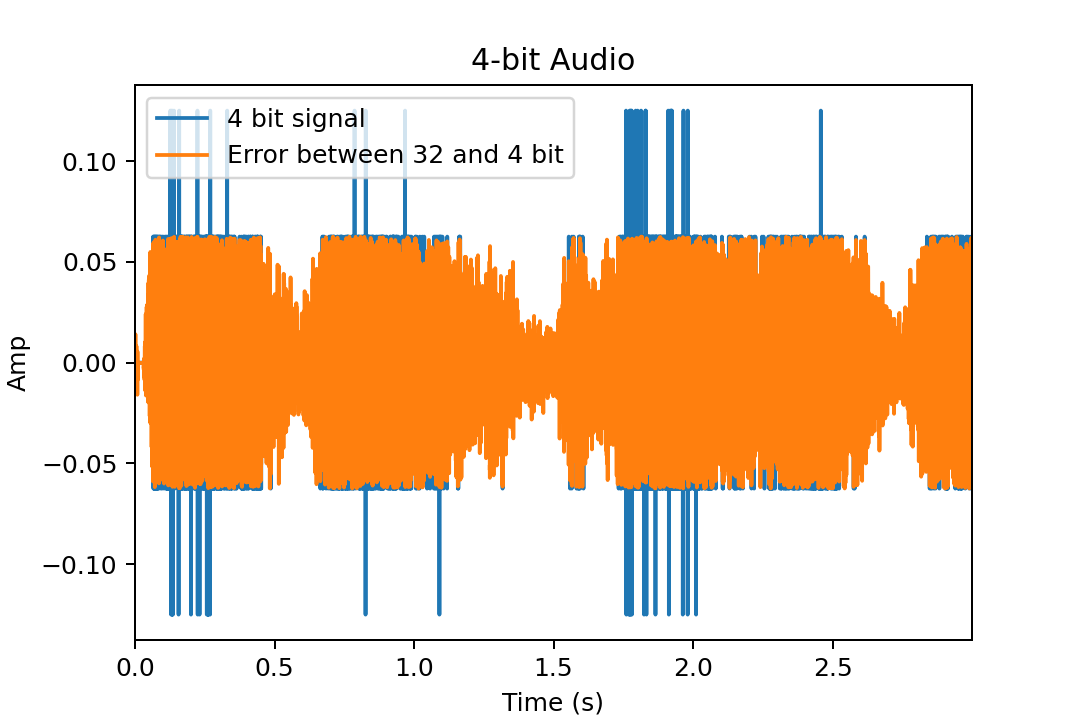

In [32]:
# The initial data is 32-bit and will be our reference
print("32-bit audio:")
IPython.display.display(Audio(audio_32bit.T, rate=fs))

dt = 1/fs; N = len(audio_32bit) 
time = np.arange(0,N*dt,dt)  
audio_32bit_norm = audio_32bit[:,0]/(2**32)   # Normalise by the number of bits

fig, axes = plt.subplots(figsize=(6, 4)) 
axes.plot(time,audio_32bit_norm)  
axes.set_title('32-bit Audio')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amp')
axes.set_xlim(time[0],time[-1])


quant_bits = np.array([16, 8, 4])  # Various bit depths to quantise
audio_quant = np.zeros([len(audio_32bit_norm),len(quant_bits)]) # For the quantised audio
audio_quant_spectrum = np.zeros([len(audio_32bit_norm),len(quant_bits)],dtype=np.cdouble) # For the spectrum of quantised audio
err_quant = np.zeros([len(audio_32bit_norm),len(quant_bits)])   # For errors between quantised audio and 32 bit

for i in np.arange(0,len(quant_bits),1):
    
    # Quantise
    n_bits = quant_bits[i]
    audio_tmp = audio_32bit_norm * (2**n_bits) # Multiply by the new max. discretisation level according to the number of bits
    audio_tmp = audio_tmp.astype(int)          # Makes an int with the new limits from n_bits, i.e. this is now a signal with a range from -2**(n_bits-1) to 2**(n_bits - 1)-1
    audio_quant[:,i] = audio_tmp/(2**n_bits)   # Normalise again
    
    # Fast Fourier Transform (FFT) of the quantised signal:
    audio_quant_spectrum[:,i] = np.fft.fft(audio_quant[:,i])
 
    # Compute error from 32 bit
    err_quant[:,i] = audio_32bit_norm - audio_quant[:,i]
    
    # Render audio
    print(str(n_bits)+"-bit audio:")
    IPython.display.display(Audio(audio_quant[:,i].T, rate=fs))  
    
    # Plot
    fig, axes = plt.subplots(figsize=(6, 4)) 
    axes.plot(time,audio_quant[:,i],label=str(n_bits)+' bit signal')  
    axes.plot(time,err_quant[:,i],label='Error between 32 and '+str(n_bits)+' bit')  
    axes.set_title(str(n_bits)+ '-bit Audio')
    axes.set_xlabel('Time (s)')
    axes.set_ylabel('Amp')
    axes.set_xlim(time[0],time[-1])
    plt.legend()




It should be fairly clear from this demonstration that as the number of bits used to represent the audio files decrease, the resulting quality decreases as well. The audio does not sound too bad at 8-bits, but there is severe distortion at 4-bits. If we observe the frequency spectrum it also reveals that there is quite a bit of broadband noise being introduced low bit rates, which checks out with the theory in that the Signal to Noise ratio is proportional to the number of bits used to quantise the signal.

<IPython.core.display.Javascript object>


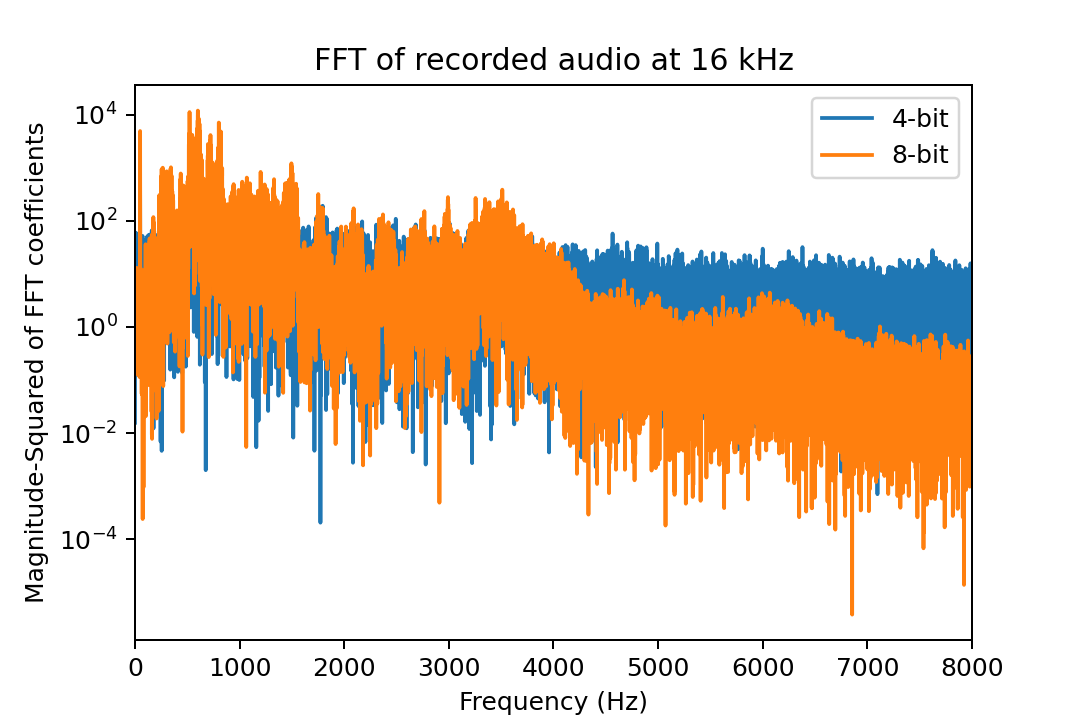

In [36]:
#Set up the frequency vector
df = fs/N  # the frequency bin spacing
freqs = np.arange(0,fs,df) # first value = DC, last value = fs-df. This means we are plotting the double-sided spectrum

fig, axes = plt.subplots(figsize=(6, 4)) 
axes.plot(freqs,np.abs(audio_quant_spectrum[:,2]**2),label = '4-bit')
axes.plot(freqs,np.abs(audio_quant_spectrum[:,1]**2),label = '8-bit')
# axes.plot(freqs,np.abs(audio_quant_spectrum[:,0]**2),label = '16-bit')
axes.set_yscale('log')  # toggle this to check out a log y-axis
axes.set_xlim(0, fs/2)
axes.set_title('FFT of recorded audio at 16 kHz')
axes.set_xlabel('Frequency (Hz)')
axes.set_ylabel('Magnitude-Squared of FFT coefficients')
plt.legend()
